In [1]:
# Import necessary libraries for data handling, model utilization, and visualization
import numpy as np
import pandas as pd
import yfinance as yf  # For collecting financial data
import matplotlib.pyplot as plt
from typing import List, Dict, Optional, Tuple
from scipy.optimize import minimize 
from datetime import datetime, timedelta
import random
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from collections import deque
# Import the custom Model class
from Model import Model

# Set the random seed for reproducibility across numpy and tensorflow
np.random.seed(123)

plt.style.use('seaborn-darkgrid')

# Define the tickers and date range with consideration of trading days
TICKERS = ['AGG','DBC','VTI','^VIX']

# Approximate number of trading days per year (useful for annualizing returns)
TRADING_DAYS_PER_YEAR = 252

# Confirm setup
print("Setup complete: libraries imported, random seed set, and tickers defined.")


Setup complete: libraries imported, random seed set, and tickers defined.


C:\Users\wiztu\AppData\Local\Temp\ipykernel_4444\1997288386.py:21: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


In [2]:
# Data Collection Step
# Objective: Fetch historical adjusted close prices for defined tickers and date range

# Download data using yfinance for the specified tickers and date range
def get_data(tickers, start_date, end_date):
    """
    Retrieves historical adjusted close prices for the given tickers and date range.
    
    Parameters:
    - tickers: List of stock ticker symbols
    - start_date: Start date for historical data
    - end_date: End date for historical data
    
    Returns:
    - DataFrame of adjusted close prices, with each column representing a ticker
    """
    # Fetch data from yfinance
    data = yf.download(tickers, start=start_date, end=end_date)['Adj Close']
    
    # Drop rows with missing values, if any, to ensure data continuity
    data.dropna(inplace=True)
    
    return data

# Fetch the data and display a quick preview
data = get_data(TICKERS, '2000-01-01', '2021-01-04')
print("Data fetched successfully. Sample data:")
print(data.head())

# Confirm data spans the expected range and has the expected number of columns
print(f"Data covers {len(data)} trading days with {len(data.columns)} assets.")


[*********************100%%**********************]  4 of 4 completed

Data fetched successfully. Sample data:
Ticker            AGG        DBC        VTI   ^VIX
Date                                              
2006-02-06  56.471344  20.889498  44.654259  13.04
2006-02-07  56.431873  20.285255  44.219509  13.59
2006-02-08  56.403683  20.198933  44.537632  12.83
2006-02-09  56.437542  20.388838  44.452793  13.12
2006-02-10  56.319202  20.017660  44.544693  12.87
Data covers 3753 trading days with 4 assets.


In [3]:
def preprocess_data(data, rolling_window=50):
    """
    Prepares data by calculating 50-day rolling averages and returns.

    Parameters:
    - data: DataFrame of historical adjusted close prices for assets
    - rolling_window: Window size for the rolling average

    Returns:
    - normalized_data: Smoothed prices, normalized to start at 1 for each asset
    - returns: Smoothed returns using a rolling mean of percentage changes
    """
    # Calculate rolling mean for prices and returns to smooth the data
    smoothed_prices = (data.rolling(window=rolling_window).mean()).dropna()
    smoothed_returns = smoothed_prices.pct_change().dropna()
    # Normalize prices to start each asset's time series at 1
    normalized_data = smoothed_prices / smoothed_prices.iloc[0]
    
    return normalized_data, smoothed_returns


# Run preprocessing and display sample data
normalized_data, smoothed_returns = preprocess_data(data)
print("Data preprocessing complete. Sample normalized data:")
print(normalized_data.head())
print("\nSample daily returns:")
print(smoothed_returns.head())


Data preprocessing complete. Sample normalized data:
Ticker           AGG       DBC       VTI      ^VIX
Date                                              
2006-04-18  1.000000  1.000000  1.000000  1.000000
2006-04-19  0.999786  1.001443  1.000798  0.997130
2006-04-20  0.999555  1.003226  1.001815  0.993875
2006-04-21  0.999332  1.005552  1.002683  0.991806
2006-04-24  0.999172  1.007249  1.003528  0.989520

Sample daily returns:
Ticker           AGG       DBC       VTI      ^VIX
Date                                              
2006-04-19 -0.000214  0.001443  0.000798 -0.002870
2006-04-20 -0.000231  0.001780  0.001016 -0.003264
2006-04-21 -0.000223  0.002318  0.000866 -0.002082
2006-04-24 -0.000160  0.001688  0.000843 -0.002305
2006-04-25 -0.000185  0.002115  0.000737 -0.001889


In [4]:
class Portfolio:
    def __init__(self, initial_cash: float, assets: pd.DataFrame):
        """
        Initializes the Portfolio object.

        Parameters:
        - initial_cash: The starting value of the portfolio in cash.
        - assets: DataFrame of asset prices (historical data).
        """
        self.initial_cash = initial_cash
        self.current_value = initial_cash
        self.assets = assets  # Historical price data for the assets
        self.weights = np.zeros(len(assets.columns))  # Initialize weights as zero
        self.portfolio_history = []  # To track portfolio value over time
        self.rebalancing_dates = []  # To store rebalancing dates

    def rebalance(self, new_weights: np.array, target_volatility = None):
        """
        Rebalances the portfolio according to new weights.

        Parameters:
        - new_weights: Numpy array of asset allocations.
        """
        if len(new_weights) != len(self.assets.columns):
            raise ValueError("Number of weights must match the number of assets.")
        self.weights = new_weights
        if target_volatility is not None:
            self.apply_volatility_scaling(target_volatility=target_volatility,rolling_window = 50)

    def calculate_initial_shares(self, initial_cash, initial_prices):
        """
        Calculates the number of shares for each asset at the start of the testing period based on
        initial cash and allocation weights.

        Parameters:
        - initial_cash: The starting cash value of the portfolio.

        Returns:
        - shares: Dictionary with tickers as keys and the initial number of shares as values.
        """
        # Calculate the dollar amount allocated to each asset
        dollar_allocation = initial_cash * self.weights

        # Calculate the number of shares for each asset
        shares = (dollar_allocation // initial_prices).astype(int)  # Floor division to get whole shares

        # Return as a dictionary for easy readability
        return dict(zip(self.assets.columns, shares))
    
    def calculate_daily_returns(self):
        """
        Applies the current weights to asset returns and updates portfolio value over time.
        """
        # Calculate daily returns for each asset
        daily_returns = self.assets.pct_change().dropna()
        
        # Calculate portfolio returns by applying weights
        portfolio_returns = np.dot(daily_returns, self.weights)

        # Track the portfolio's value over time by compounding the returns
        for daily_ret in portfolio_returns:
            self.current_value *= (1 + daily_ret)
            self.portfolio_history.append(self.current_value)

    def update_portfolio_value(self, date):
        """
        Updates the portfolio value for a single date.
        """
        # Get the index of the date
        date_index = self.assets.index.get_loc(date)
        if date_index == 0:
            # First day, no previous day to compute return
            self.portfolio_history.append(self.current_value)
            return
        # Get the asset returns for that day
        previous_date = self.assets.index[date_index - 1]
        daily_return = self.assets.loc[date] / self.assets.loc[previous_date] - 1
        # Calculate portfolio return
        portfolio_return = np.dot(daily_return.values, self.weights)
        # Update portfolio value
        self.current_value *= (1 + portfolio_return)
        # Append to history
        self.portfolio_history.append(self.current_value)


    def track_portfolio_performance(self):
        """
        Tracks and prints the portfolio performance over time.
        """
        for date, value in zip(self.assets.index[1:], self.portfolio_history):
            print(f"Date: {date}, Portfolio Value: {value}")
    
    def reset(self):
        self.current_cash = self.initial_cash
        self.assets = self.initial_assets.copy()
        self.weights = np.zeros(len(self.assets.columns))  # Reset to no investments
        self.portfolio_history = []
        self.rebalancing_dates = []
        return self.assets.iloc[0].values

    def get_portfolio_value(self):
        """
        Returns the current value of the portfolio.
        """
        return self.current_value
    
    def plot_portfolio_value(self):
        """
        Plots the portfolio value over time.
        """
        plt.figure(figsize=(10, 6))
        plt.plot(self.assets.index[1:], self.portfolio_history, label="Portfolio Value")
        plt.title("Portfolio Value Over Time")
        plt.xlabel("Date")
        plt.ylabel("Portfolio Value")
        plt.legend()
        plt.show()

    def apply_volatility_scaling(self, target_volatility=0.1, rolling_window=50):
        """
        Scales portfolio allocations based on the ratio of target volatility to current asset volatilities.
        
        Parameters:
        - target_volatility: The target annualized volatility for the portfolio (e.g., 0.1 for 10%).
        - rolling_window: The window size (in days) for calculating each asset's rolling volatility.
        
        Returns:
        - Scaled weights to achieve the target volatility for each asset.
        """
        # Calculate daily returns of the portfolio assets
        daily_returns = self.assets.pct_change().dropna()
        
        # Calculate rolling volatility (annualized) for each asset over the rolling window
        asset_volatilities = daily_returns.rolling(window=rolling_window).std().iloc[-1] * np.sqrt(252)
        asset_volatilities = asset_volatilities.dropna()
        
        # Compute scaling factor for each asset to achieve the target volatility
        scaling_factors = target_volatility / asset_volatilities

        # Scale weights by the scaling factors
        self.weights = self.weights * scaling_factors

        # Normalize weights to ensure they sum to 1
        self.weights = self.weights / np.sum(self.weights)

        # Debugging: Print intermediate values to verify calculations
        print(f"Asset Volatilities: {asset_volatilities}")
        print(f"Scaling Factors: {scaling_factors}")
        print(f"Scaled and Normalized Weights: {self.weights}")
        
        return self.weights  # Return the scaled weights


In [5]:
def train_and_rebalance_portfolio(portfolio: Portfolio, model: Model):
    """
    Trains the LSTM model once over the full dataset and returns a single set of allocation weights.

    Parameters:
    - portfolio: An instance of the Portfolio class.
    - model: An instance of the Model class for training.
    
    Returns:
    - allocations: Final optimized weights for each asset in the portfolio.
    """
    # Use the entire dataset for training
    train_data = portfolio.assets

    # Get allocations from the model
    allocations = model.get_allocations(train_data)

    # Rebalance the portfolio with the optimized weights (if needed for tracking)
    portfolio.rebalance(allocations)

    # Return the final allocation weights
    return allocations


In [6]:
def calculate_metrics(portfolio_values):
    """
    Calculates performance metrics for the portfolio.

    Parameters:
    - portfolio_values: List of daily portfolio values over the testing period.

    Returns:
    - metrics: Dictionary containing Sharpe Ratio, Sortino Ratio, and Max Drawdown.
    """
    # Convert portfolio values to daily returns
    portfolio_returns = np.diff(portfolio_values) / portfolio_values[:-1]
    
    # Calculate Sharpe Ratio
    mean_return = np.mean(portfolio_returns)
    std_dev = np.std(portfolio_returns)
    sharpe_ratio = mean_return / std_dev * np.sqrt(TRADING_DAYS_PER_YEAR)
    
    # Calculate Sortino Ratio
    downside_returns = portfolio_returns[portfolio_returns < 0]
    downside_std_dev = np.std(downside_returns)
    sortino_ratio = mean_return / downside_std_dev * np.sqrt(TRADING_DAYS_PER_YEAR)
    
    # Calculate Maximum Drawdown
    cumulative_returns = np.maximum.accumulate(portfolio_values) - portfolio_values
    max_drawdown = np.max(cumulative_returns / np.maximum.accumulate(portfolio_values))
    
    return {
        "Sharpe Ratio": sharpe_ratio,
        "Sortino Ratio": sortino_ratio,
        "Max Drawdown": max_drawdown
    }

In [7]:
def equal_weighted_strategy(returns):
    """
    Creates an equal-weighted portfolio.

    Parameters:
    - returns: DataFrame of daily returns for each asset.

    Returns:
    - equal_weights: Numpy array of equal weights for each asset.
    """
    num_assets = returns.shape[1]
    equal_weights = np.ones(num_assets) / num_assets
    return equal_weights

def mean_variance_optimized_strategy(returns):
    """
    Creates a mean-variance optimized portfolio by maximizing the Sharpe Ratio.

    Parameters:
    - returns: DataFrame of daily returns for each asset.

    Returns:
    - optimized_weights: Numpy array of optimized weights for each asset.
    """
    mean_returns = returns.mean()
    cov_matrix = returns.cov()
    
    def neg_sharpe(weights):
        portfolio_return = np.dot(weights, mean_returns)
        portfolio_std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
        return -portfolio_return / portfolio_std

    # Constraints: Weights must sum to 1, and each weight must be between 0 and 1
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = tuple((0, 1) for _ in range(returns.shape[1]))

    result = minimize(neg_sharpe, np.ones(returns.shape[1]) / returns.shape[1], bounds=bounds, constraints=constraints)
    optimized_weights = result.x
    
    return optimized_weights

def maximum_diversification(returns):
    """
    Perform maximum diversification optimization based on the given returns.

    Parameters:
    - returns: DataFrame of daily returns for each asset.

    Returns:
    - optimal_weights: Array of portfolio weights that maximize diversification.
    """
    # Calculate asset volatilities (standard deviation of each asset’s returns)
    asset_volatilities = returns.std()

    # Calculate the covariance matrix of returns
    cov_matrix = returns.cov()

    # Define the diversification ratio to be maximized
    def neg_diversification_ratio(weights):
        # Calculate the weighted average asset volatility
        weighted_volatility = np.dot(weights, asset_volatilities)
        
        # Calculate the portfolio volatility as the weighted covariance matrix
        portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
        
        # Diversification ratio (we negate this because we want to maximize it)
        diversification_ratio = weighted_volatility / portfolio_volatility
        return -diversification_ratio  # Negate to turn this into a minimization problem

    # Constraints: weights sum to 1, and each weight between 0 and 1 (long-only portfolio)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = tuple((0, 1) for _ in range(len(asset_volatilities)))

    # Initial guess (equal allocation)
    init_guess = np.ones(len(asset_volatilities)) / len(asset_volatilities)

    # Optimize to find weights that maximize diversification ratio
    result = minimize(neg_diversification_ratio, init_guess, bounds=bounds, constraints=constraints)
    optimal_weights = result.x
    
    return optimal_weights


In [8]:
def generalized_rolling_validation(data, allocation_strategy, train_years=2, test_months=12, initial_cash=100000):
    results = []
    start_date = data.index[0]
    final_values = []

    while True:
        # Define training and testing windows
        train_end = start_date + pd.DateOffset(years=train_years)
        test_start = train_end + timedelta(days=1)
        test_end = test_start + pd.DateOffset(months=test_months)

        # Stop if testing period exceeds available data
        if test_end > data.index[-1]:
            break

        # Split data into train and test sets for this roll
        train_data = data.loc[start_date:train_end]
        test_data = data.loc[test_start:test_end]

        # Preprocess the training and testing data
        normalized_train, train_returns = preprocess_data(train_data)
        normalized_test, test_returns = preprocess_data(test_data)

        # Train the model and get allocations
        if allocation_strategy == train_and_rebalance_portfolio:
            model = Model()
            training_portfolio = Portfolio(initial_cash=initial_cash, assets=train_data)
            # Pass normalized and return data to the LSTM-based allocation function
            final_allocations = allocation_strategy(training_portfolio, model=model)
        
        else:
            # For non-LSTM strategies, use `train_returns` directly
            final_allocations = allocation_strategy(train_returns)

        # Initialize the testing portfolio with final allocations
        testing_portfolio = Portfolio(initial_cash=initial_cash, assets=test_data)
        testing_portfolio.portfolio_history = []
        testing_portfolio.rebalance(final_allocations)  # Initial rebalancing with optimized weights

        # Perform daily rebalancing or just track daily returns, as required
        testing_portfolio.calculate_daily_returns()
        final_values.append(testing_portfolio.get_portfolio_value())

        # Calculate performance metrics for this roll
        metrics = calculate_metrics(testing_portfolio.portfolio_history)

        # Store results for this roll
        results.append({
            'train_period': (start_date, train_end),
            'test_period': (test_start, test_end),
            'metrics': metrics
        })

        # Plot the portfolio value over time for this roll
        testing_portfolio.plot_portfolio_value()

        # Move the start date forward for the next roll
        start_date = start_date + pd.DateOffset(months=test_months)

    return results, final_values


[*********************100%%**********************]  4 of 4 completed
c:\Users\wiztu\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: -0.1533
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: -0.2042
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: -0.1507
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: -0.1943
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: -0.2024
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: -0.2008
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: -0.1953
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: -0.2198
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: -0.2149
Epoch 10/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: -0.1995
Epoch 11/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: -0.1599
Epoch 12/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: -0.2451
Epoch 13/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: -0.2144
Epoch 14/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: -0.2295
Epoch 15/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: -0.3022
Epoc

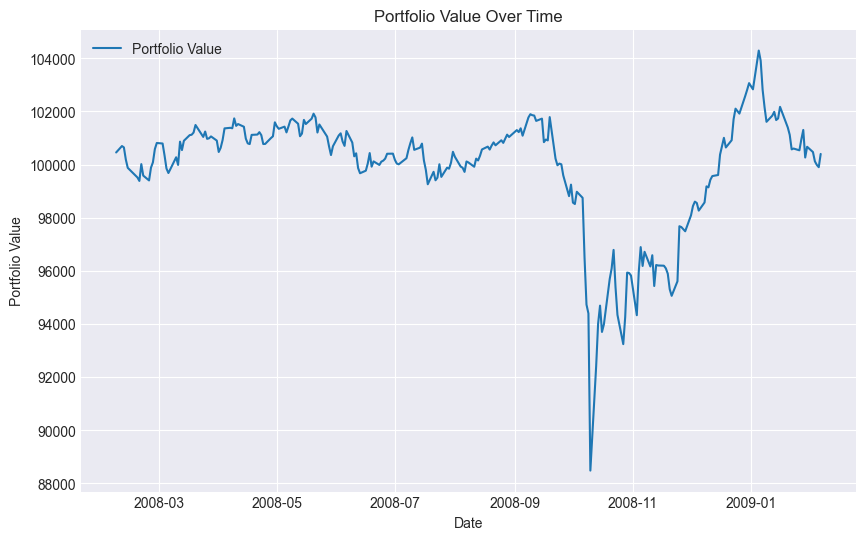

Epoch 1/100


c:\Users\wiztu\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: -0.1069
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: -0.1119
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: -0.0236
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: -0.0693
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: -0.0921
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: -0.0816
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: -0.1446
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: -0.0730
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: -0.0992
Epoch 10/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: -0.1134
Epoch 11/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: -0.1214
Epoch 12/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: -0.1192
Epoch 13/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: -0.1259
Epoch 14/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: -0.1279
Epoch 15/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: -0.1165
Epoch 16/100
8/8

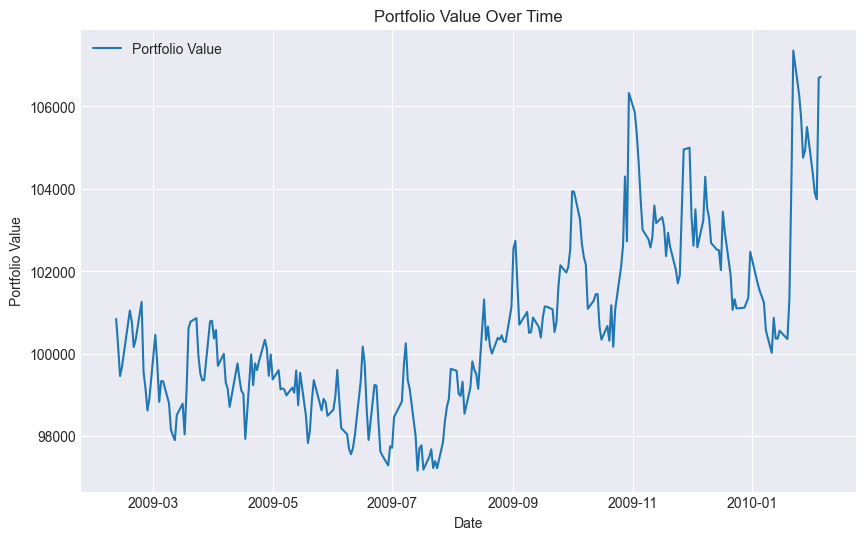

Epoch 1/100


c:\Users\wiztu\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: -0.0959
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: -0.0769
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: -0.1395
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: -0.0847
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: -0.1158
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: -0.1005
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: -0.1522
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: -0.1458
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: -0.1017
Epoch 10/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: -0.0717
Epoch 11/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: -0.1248
Epoch 12/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: -0.1125
Epoch 13/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: -0.1394
Epoch 14/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: -0.1399
Epoch 15/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: -0.1420
Epoch 16/100
8/8

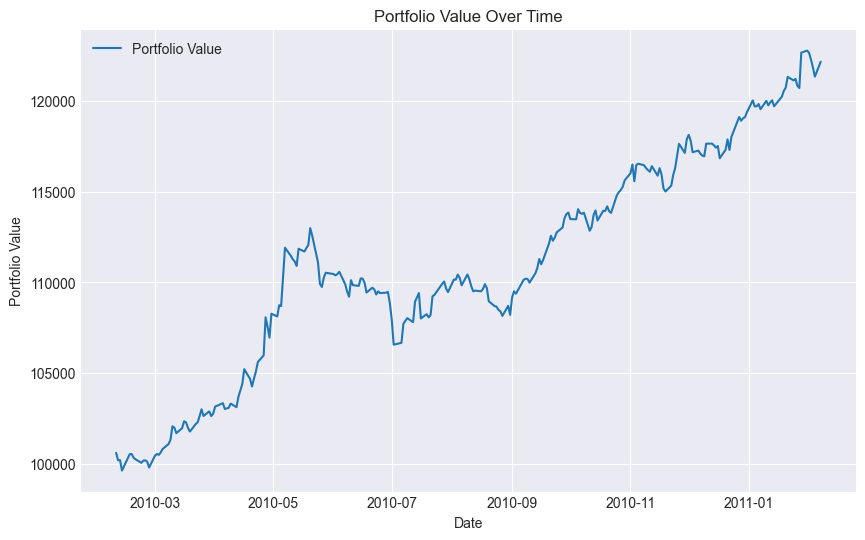

Epoch 1/100


c:\Users\wiztu\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: -0.0402  
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: -0.0912
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: -0.1350
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: -0.1666
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: -0.1890
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: -0.2021
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: -0.1913
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: -0.2483
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: -0.2429
Epoch 10/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: -0.2296
Epoch 11/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: -0.2415
Epoch 12/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: -0.1928
Epoch 13/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: -0.1844
Epoch 14/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: -0.2189
Epoch 15/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: -0.2355
Epoch 16/100
8

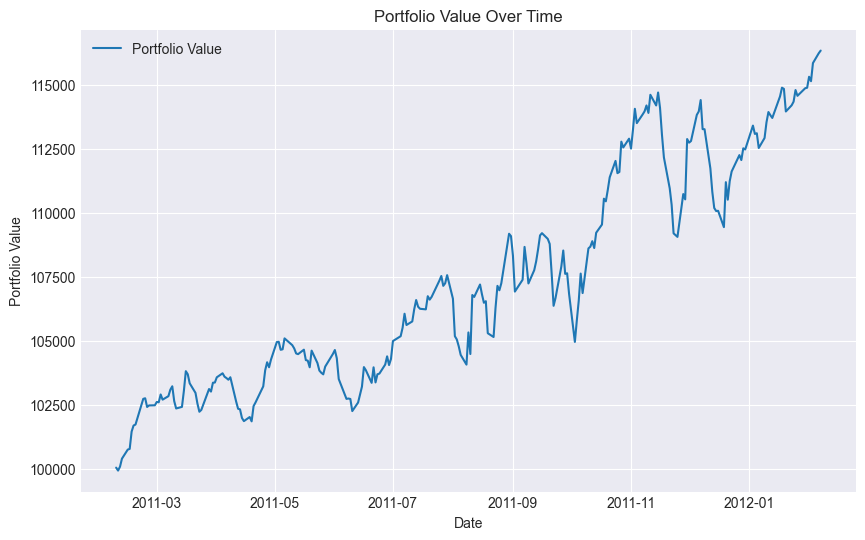

Epoch 1/100


c:\Users\wiztu\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 0.0343
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: -0.0637
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: -0.0661
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: -0.1328
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: -0.1034
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: -0.2152
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: -0.1637
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: -0.1963
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: -0.1714
Epoch 10/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: -0.1575
Epoch 11/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: -0.1944
Epoch 12/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: -0.2014
Epoch 13/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: -0.1356
Epoch 14/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: -0.1643
Epoch 15/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: -0.1509
Epoch 16/100
8/8 

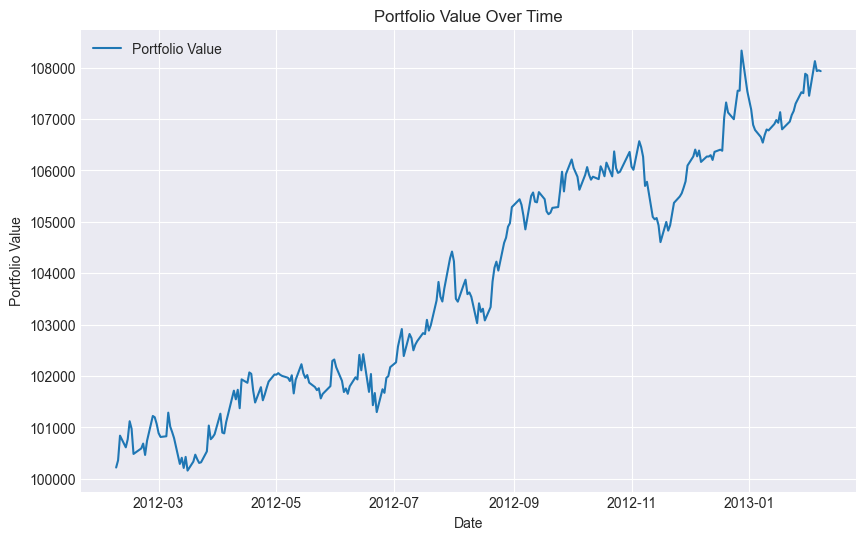

Epoch 1/100


c:\Users\wiztu\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: -0.0878
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: -0.1054
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: -0.1576
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: -0.1571
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: -0.2074
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: -0.1997
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: -0.1845
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: -0.1544
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: -0.1881
Epoch 10/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: -0.1745
Epoch 11/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: -0.1877
Epoch 12/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: -0.1840
Epoch 13/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: -0.2271
Epoch 14/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: -0.2064
Epoch 15/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: -0.1905
Epoch 16/100
8/8

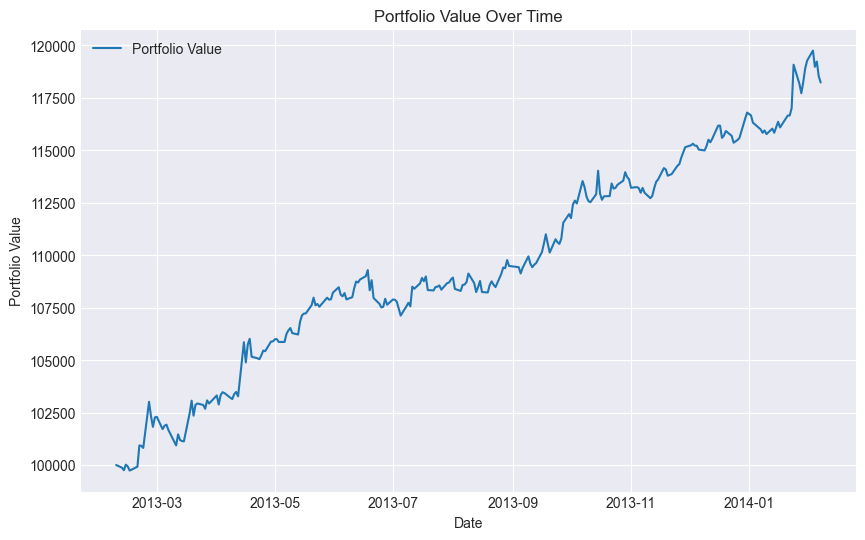

Epoch 1/100


c:\Users\wiztu\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: -0.0590
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: -0.0660
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: -0.0422
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: -0.0110
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: -0.1038
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: -0.0756
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: -0.0884
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: -0.1526
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: -0.0706
Epoch 10/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: -0.1789
Epoch 11/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: -0.1738
Epoch 12/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: -0.1535
Epoch 13/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: -0.1773
Epoch 14/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: -0.1963
Epoch 15/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: -0.1447
Epoch 16/100
8/8

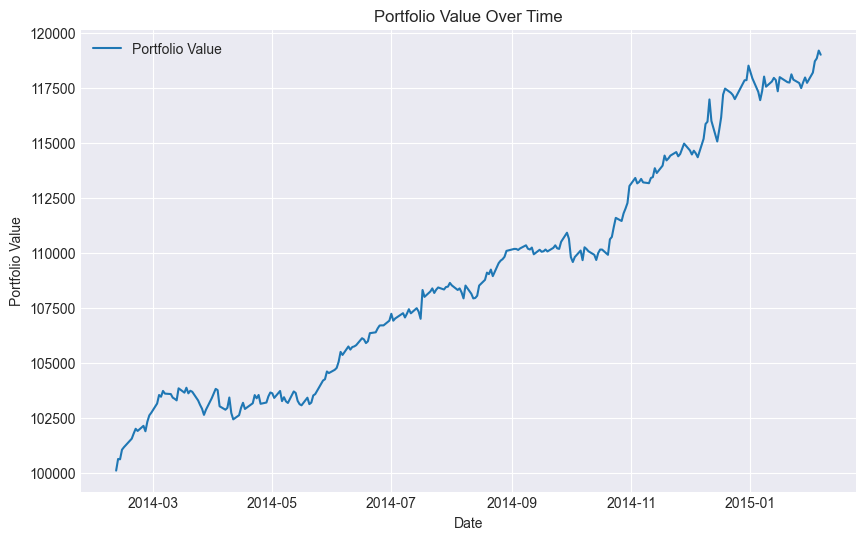

Epoch 1/100


c:\Users\wiztu\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: -0.0129
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: -0.0794
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: -0.0751
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: -0.2442
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: -0.2541
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: -0.2075
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: -0.1982
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: -0.1794
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: -0.2337
Epoch 10/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: -0.2018
Epoch 11/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: -0.2025
Epoch 12/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: -0.2309
Epoch 13/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: -0.2229
Epoch 14/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: -0.2343
Epoch 15/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: -0.2189
Epoch 16/100
8/8

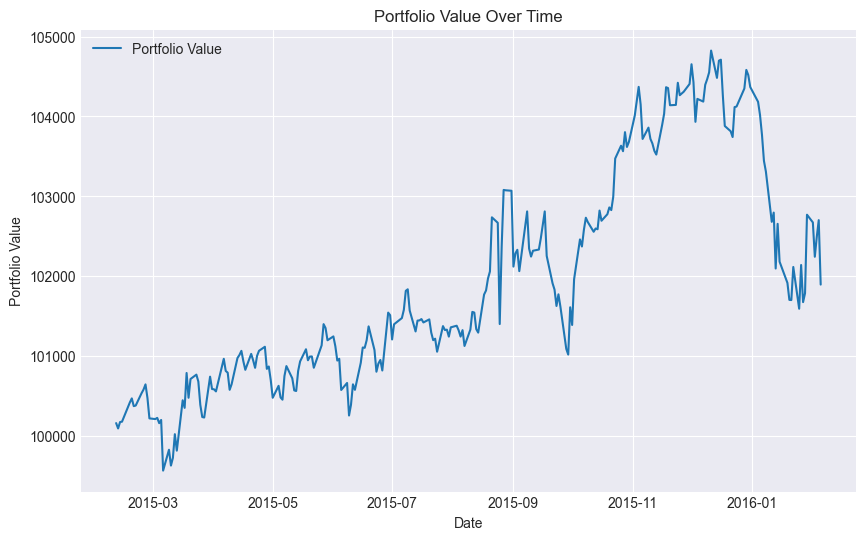

Epoch 1/100


c:\Users\wiztu\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: -0.0137
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: -0.0793
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: -0.0525
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: -0.0887
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: -0.1199
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: -0.1051
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: -0.1259
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: -0.1407
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: -0.1488
Epoch 10/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: -0.0973
Epoch 11/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: -0.1787
Epoch 12/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: -0.0647
Epoch 13/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: -0.1657
Epoch 14/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: -0.1337
Epoch 15/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: -0.1576
Epoch 16/100
8/8

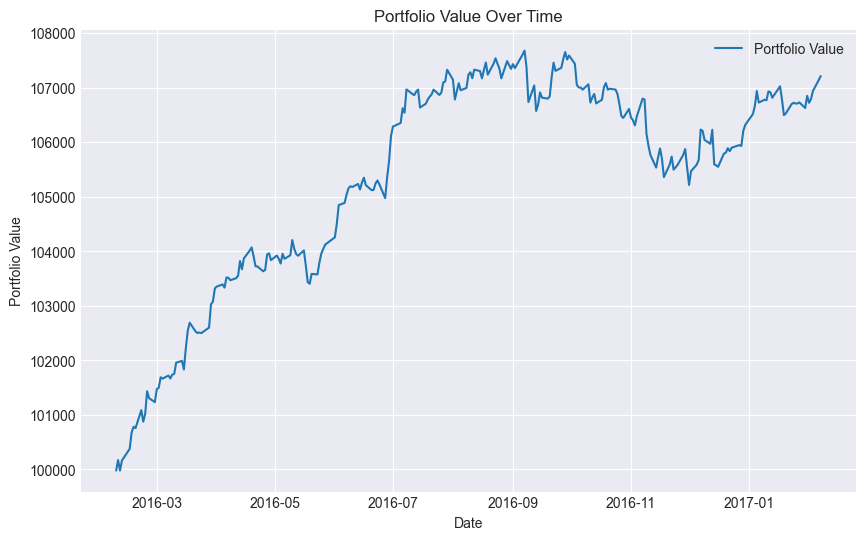

Epoch 1/100


c:\Users\wiztu\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: -0.0192
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: -0.0816
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: -0.1186
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: -0.0852
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: -0.0736
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: -0.1003
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: -0.1087
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: -0.0925
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: -0.1739
Epoch 10/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: -0.1382
Epoch 11/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: -0.1613
Epoch 12/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: -0.1569
Epoch 13/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: -0.1222
Epoch 14/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: -0.0723
Epoch 15/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: -0.1362
Epoch 16/100
8/8

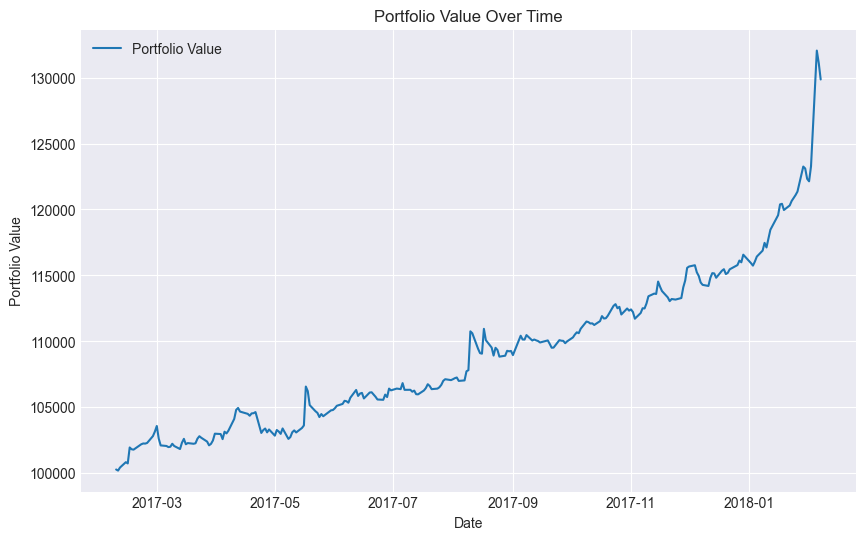

Epoch 1/100


c:\Users\wiztu\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: -0.0878
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: -0.0432
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: -0.1167
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: -0.1237
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: -0.1226
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: -0.2367
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: -0.2407
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: -0.2309
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: -0.2686
Epoch 10/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: -0.2851
Epoch 11/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: -0.2515
Epoch 12/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: -0.2941
Epoch 13/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: -0.3117
Epoch 14/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: -0.2808
Epoch 15/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: -0.2420
Epoch 16/100
8/8

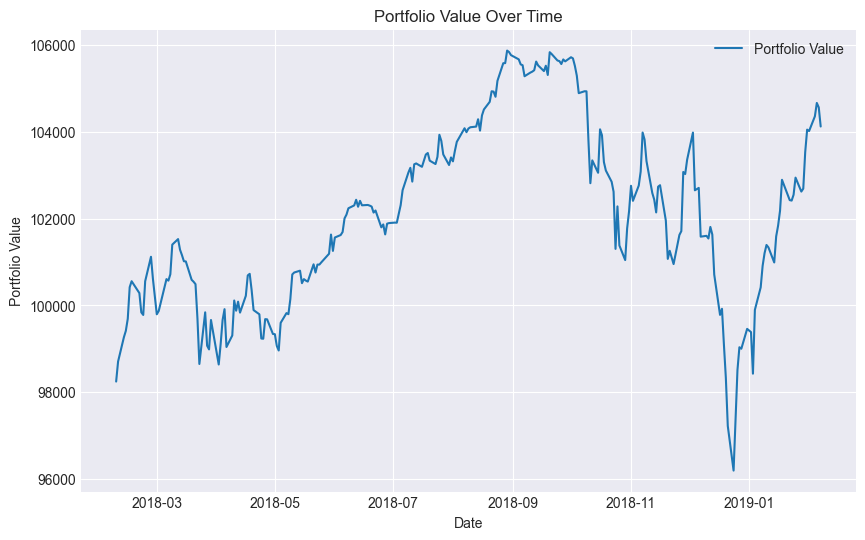

Epoch 1/100


c:\Users\wiztu\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: -0.1012
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: -0.1562
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: -0.1624
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: -0.1523
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: -0.1363
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: -0.1613
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: -0.1803
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: -0.2288
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: -0.1457
Epoch 10/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: -0.0957
Epoch 11/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: -0.1170
Epoch 12/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: -0.0960
Epoch 13/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: -0.1189
Epoch 14/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: -0.2547
Epoch 15/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: -0.2318
Epoch 16/100
8/8

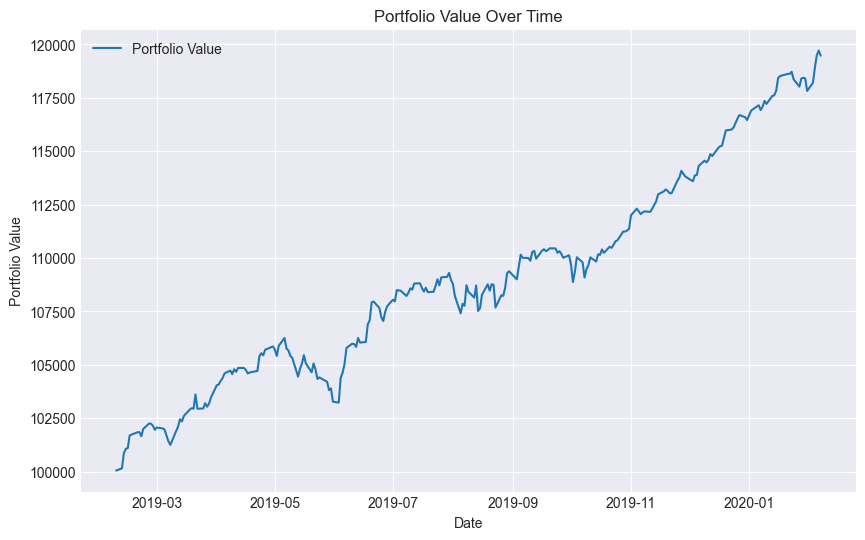

LSTM Results: [{'train_period': (Timestamp('2006-02-06 00:00:00'), Timestamp('2008-02-06 00:00:00')), 'test_period': (Timestamp('2008-02-07 00:00:00'), Timestamp('2009-02-07 00:00:00')), 'metrics': {'Sharpe Ratio': 0.05286808080528404, 'Sortino Ratio': 0.05796393290120336, 'Max Drawdown': 0.13178792389138655}}, {'train_period': (Timestamp('2007-02-06 00:00:00'), Timestamp('2009-02-06 00:00:00')), 'test_period': (Timestamp('2009-02-07 00:00:00'), Timestamp('2010-02-07 00:00:00')), 'metrics': {'Sharpe Ratio': 0.5227398663736846, 'Sortino Ratio': 1.1561266612570646, 'Max Drawdown': 0.059253297210712805}}, {'train_period': (Timestamp('2008-02-06 00:00:00'), Timestamp('2010-02-06 00:00:00')), 'test_period': (Timestamp('2010-02-07 00:00:00'), Timestamp('2011-02-07 00:00:00')), 'metrics': {'Sharpe Ratio': 2.734928002541445, 'Sortino Ratio': 4.78391025634893, 'Max Drawdown': 0.056912952373214074}}, {'train_period': (Timestamp('2009-02-06 00:00:00'), Timestamp('2011-02-06 00:00:00')), 'test_per

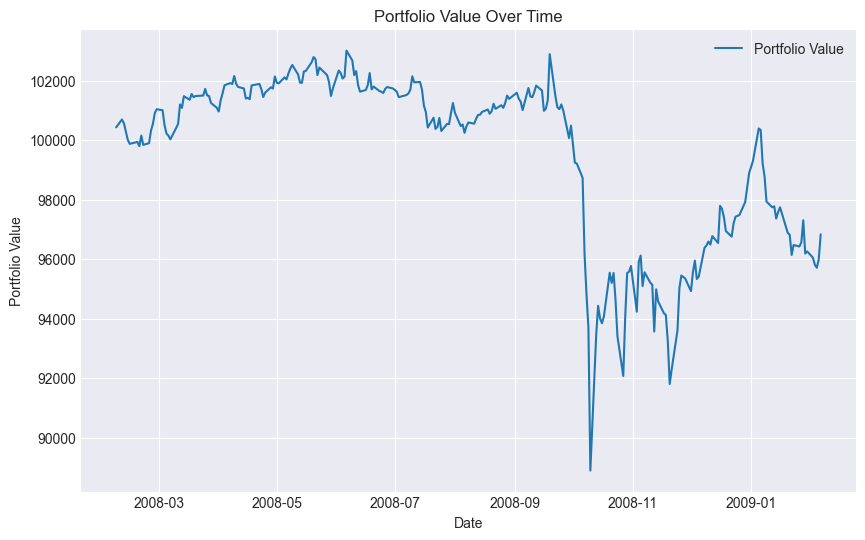

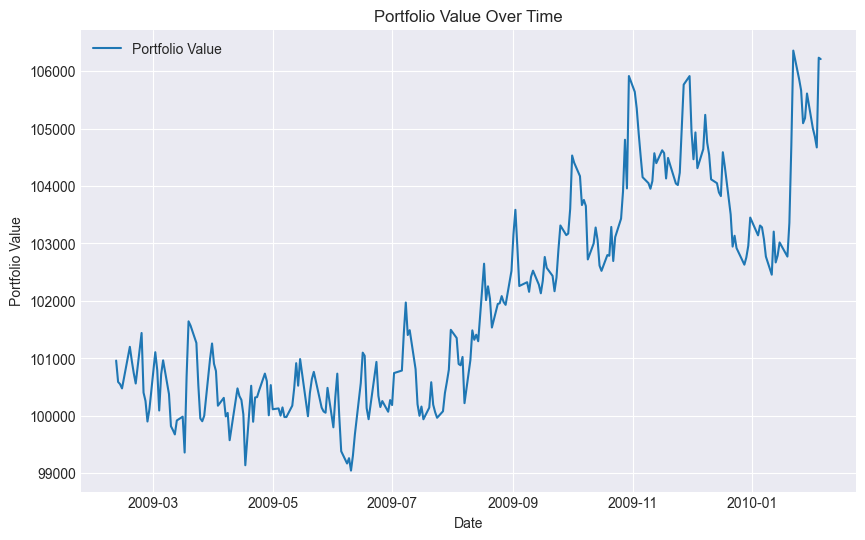

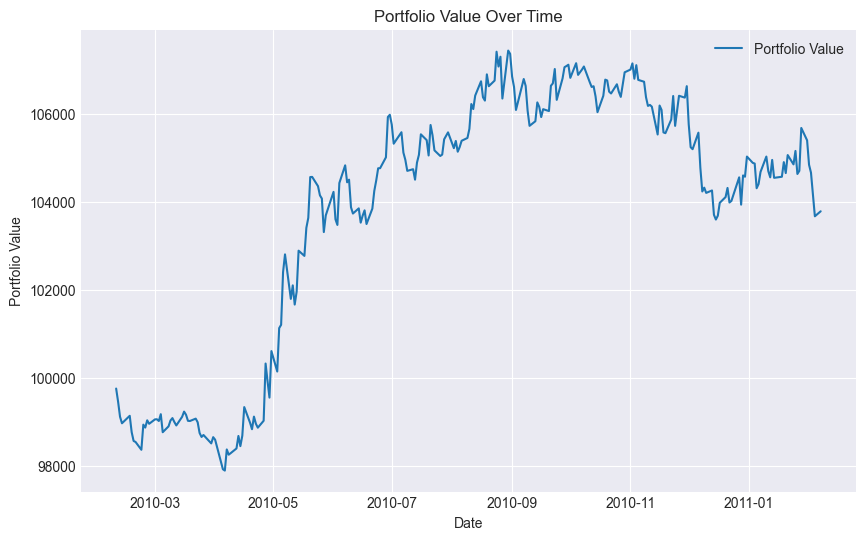

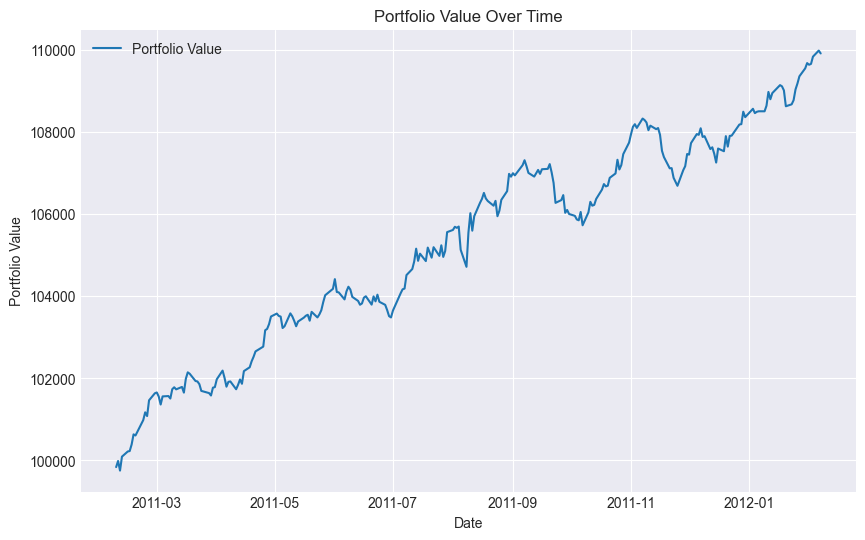

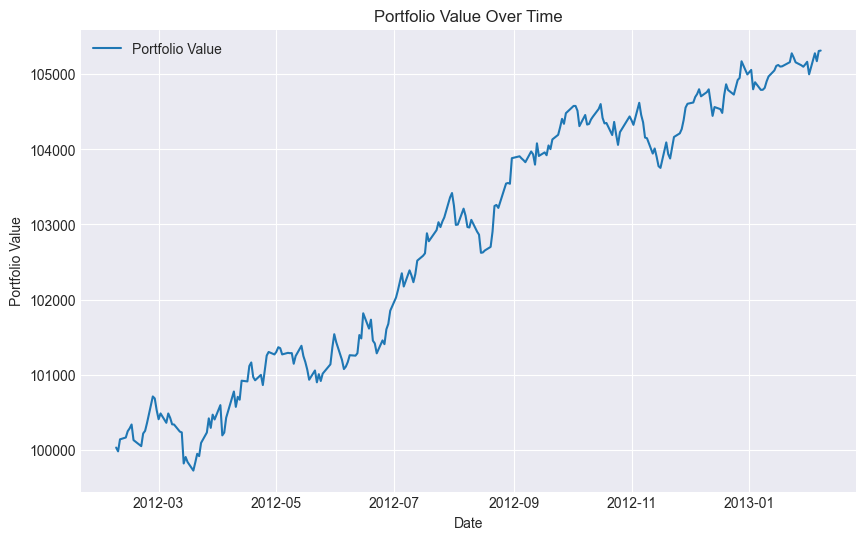

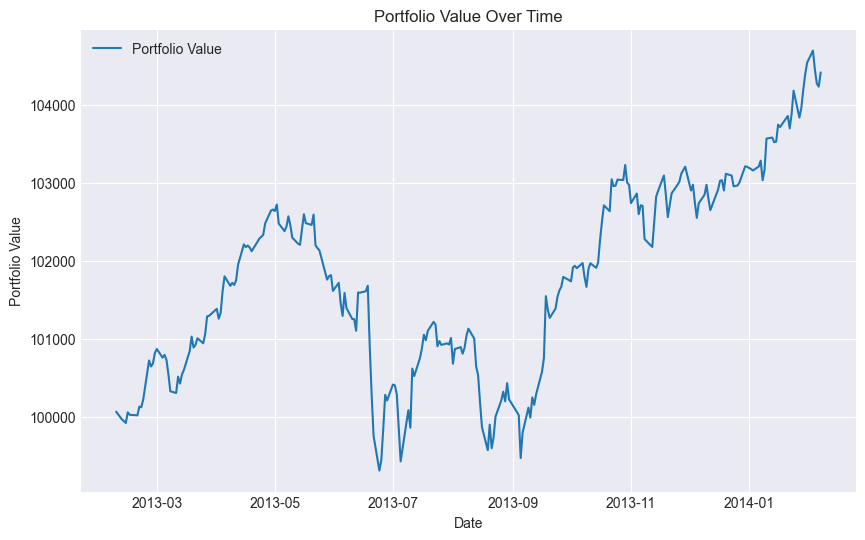

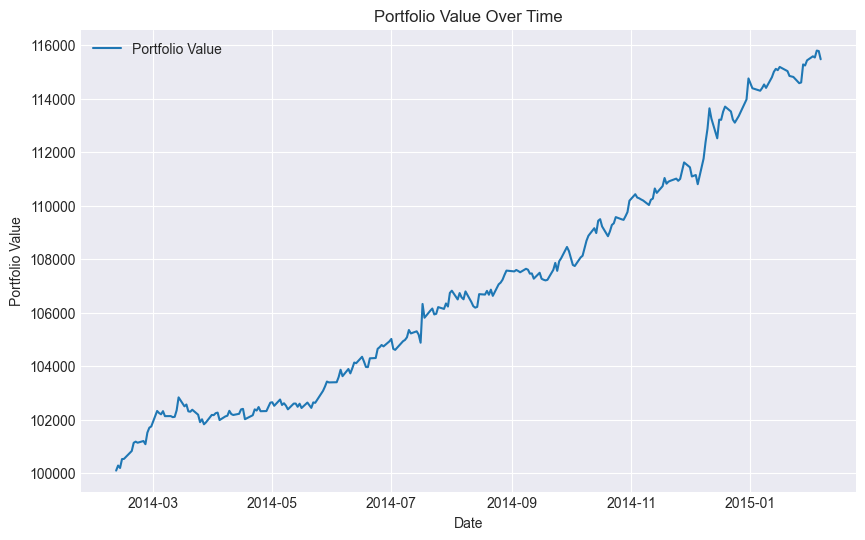

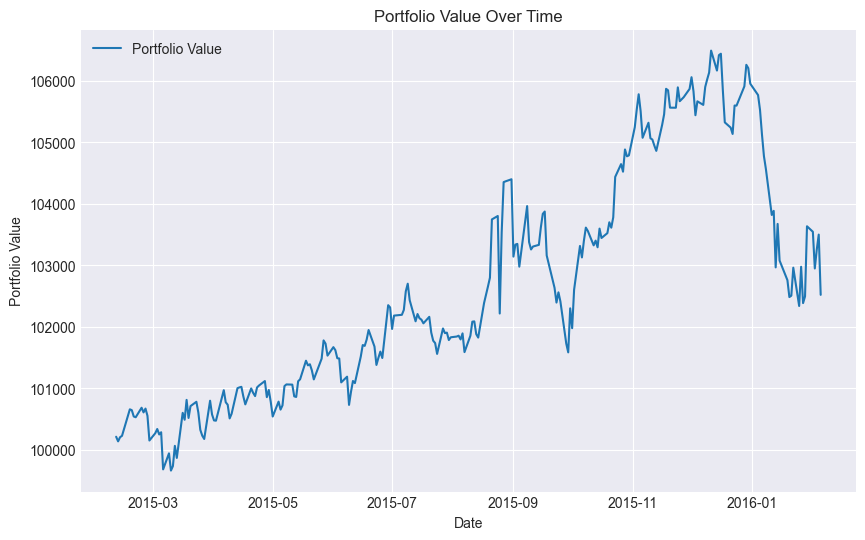

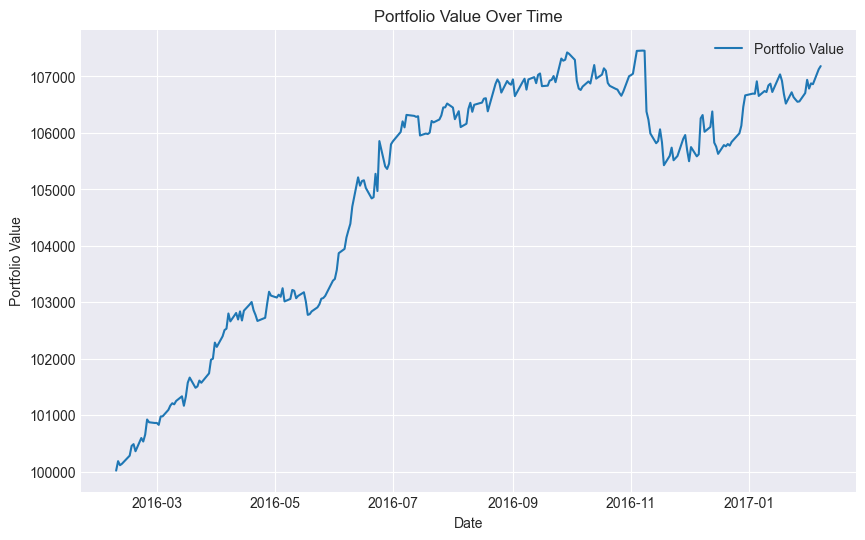

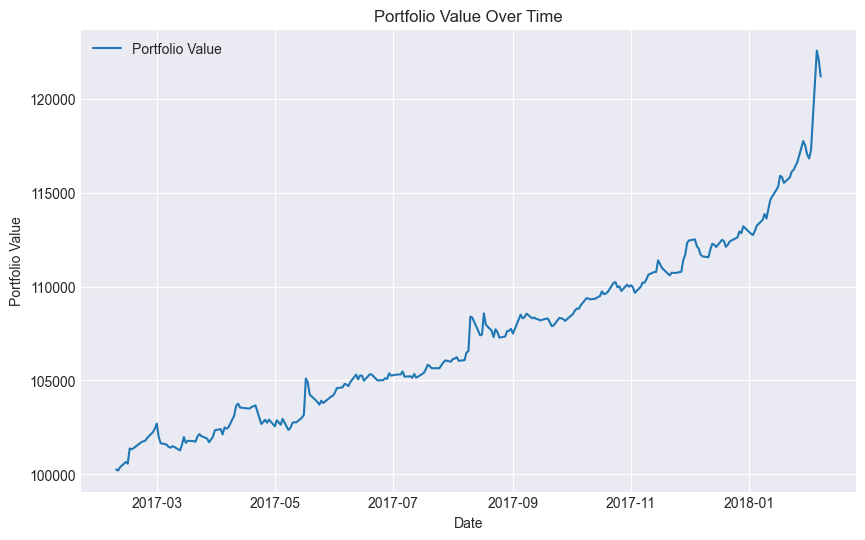

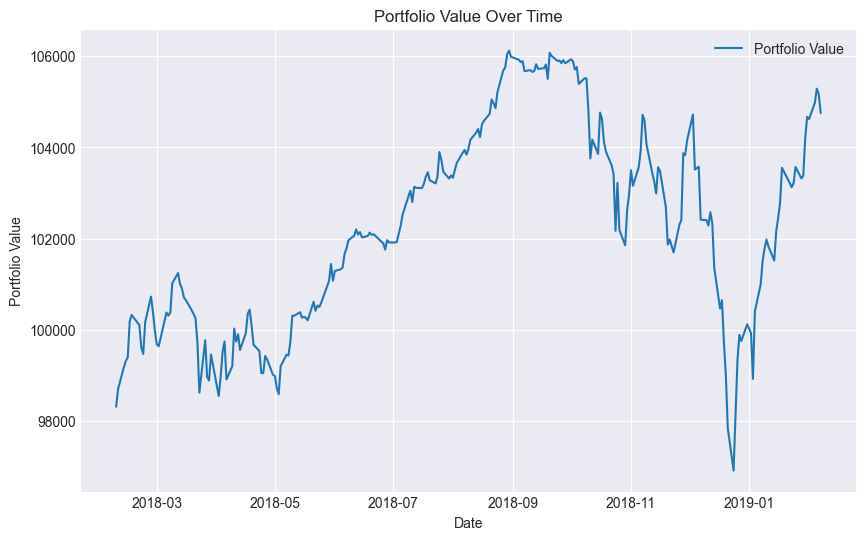

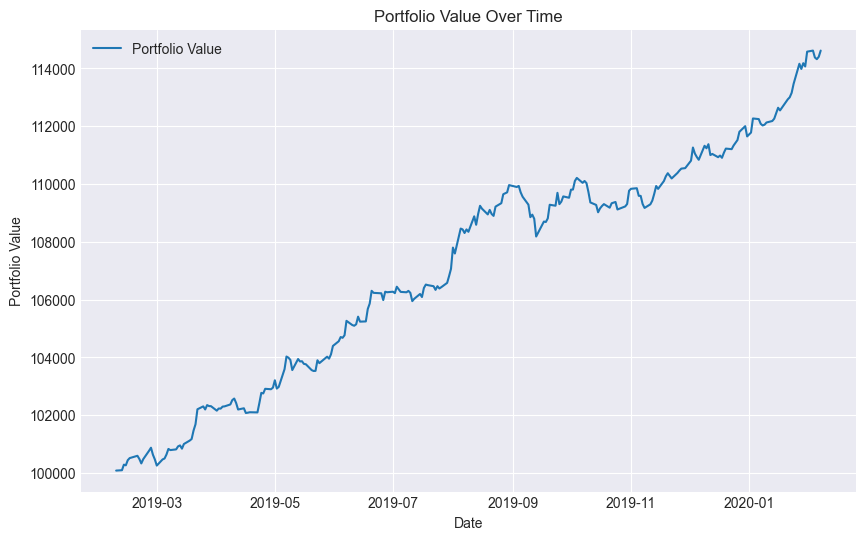

Mean-Variance Optimization Results: [{'train_period': (Timestamp('2006-02-06 00:00:00'), Timestamp('2008-02-06 00:00:00')), 'test_period': (Timestamp('2008-02-07 00:00:00'), Timestamp('2009-02-07 00:00:00')), 'metrics': {'Sharpe Ratio': -0.26326449811212915, 'Sortino Ratio': -0.3192167605188959, 'Max Drawdown': 0.1370727630567195}}, {'train_period': (Timestamp('2007-02-06 00:00:00'), Timestamp('2009-02-06 00:00:00')), 'test_period': (Timestamp('2009-02-07 00:00:00'), Timestamp('2010-02-07 00:00:00')), 'metrics': {'Sharpe Ratio': 0.6975433138371995, 'Sortino Ratio': 1.4101552711420984, 'Max Drawdown': 0.03265545590035627}}, {'train_period': (Timestamp('2008-02-06 00:00:00'), Timestamp('2010-02-06 00:00:00')), 'test_period': (Timestamp('2010-02-07 00:00:00'), Timestamp('2011-02-07 00:00:00')), 'metrics': {'Sharpe Ratio': 0.6969528293652514, 'Sortino Ratio': 1.2752078269571294, 'Max Drawdown': 0.03574772318826585}}, {'train_period': (Timestamp('2009-02-06 00:00:00'), Timestamp('2011-02-06

In [9]:
# Define tickers and data parameters
tickers = ['VTI', 'AGG', 'DBC','^VIX']
data = get_data(tickers, '2006-01-01', '2021-01-04')
# Rolling validation with LSTM-based optimization (with periodic rebalancing)
lstm_results,lstm_values = generalized_rolling_validation(data, train_and_rebalance_portfolio)
print("LSTM Results:", lstm_results)
print("Final Portfolio Values:", lstm_values)
# Rolling validation with mean-variance optimization
mvo_results,mvo_values= generalized_rolling_validation(data, mean_variance_optimized_strategy)
print("Mean-Variance Optimization Results:", mvo_results)
print("Final Portfolio Values:", mvo_values)    


In [ ]:
diff = [a - b for a, b in zip(lstm_values, mvo_values)]
print(diff)
print("Mean of the difference:", np.mean(diff))
#average profit/average loss, a = final portfolio value for lstm, b = final value for mvo, starting cash = 100000

# Calculate the average profit/average loss ratio
average_profit = np.mean([a - 100000 for a in lstm_values if a > 100000])
average_loss = 1
average_loss_calc = np.mean([100000 - b for b in mvo_values if b < 100000])
if average_loss_calc != 0:
    average_loss = average_loss_calc
profit_loss_ratio = average_profit / average_loss
print("LSTM profit/loss ratio:", profit_loss_ratio)

average_profit = np.mean([b - 100000 for b in mvo_values if b > 100000])
average_loss = np.mean([100000 - b for b in mvo_values if b < 100000])
profit_loss_ratio = average_profit / average_loss
print("MVO profit/loss ratio:", profit_loss_ratio)


[3570.237361375155, 511.2628049866471, 18383.244436676003, 6440.225368304775, 2618.106354779782, 13818.628721298752, 3546.414930896324, -626.0564310703194, 31.721748950862093, 8679.3837429962, -626.0808570302761, 4852.045574986012]
Mean of the difference: 5099.927813095826
12783.132525122317
nan
LSTM profit/loss ratio: nan
MVO profit/loss ratio: 2.7347806055740693


c:\Users\wiztu\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\wiztu\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
